# VAE bac à sable v2

source : https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [1]:
import torch
import torch.optim as optim
from sklearn.preprocessing import minmax_scale
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import os
from PIL import Image
import pandas as pd
import cv2

In [32]:
# data = pd.DataFrame([cv2.cvtColor(cv2.resize(cv2.imread(f"cat/{path}"), (64, 64)), cv2.COLOR_BGR2GRAY).flatten() for path in os.listdir("cat")])
data = pd.read_csv("canard.csv", header=None, index_col=None)

In [33]:
data

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,229.0,...,179.0,231.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
1,255.0,255.0,255.0,255.0,255.0,255.0,222.0,169.0,233.0,229.0,...,237.0,249.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
2,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,229.0,...,180.0,232.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
3,255.0,255.0,255.0,255.0,255.0,255.0,253.0,238.0,235.0,62.0,...,184.0,235.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,236.0,79.0,...,237.0,250.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,255.0,255.0,255.0,255.0,255.0,255.0,255.0,253.0,221.0,187.0,...,175.0,233.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4996,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,210.0,79.0,...,188.0,238.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4997,255.0,255.0,255.0,255.0,255.0,255.0,250.0,240.0,210.0,56.0,...,239.0,250.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4998,255.0,255.0,255.0,255.0,255.0,255.0,255.0,253.0,221.0,187.0,...,237.0,250.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [34]:
dims = (28, 28)

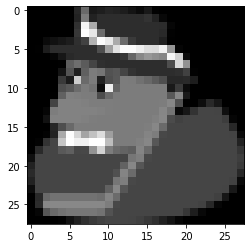

In [35]:
plt.imshow(np.array(data.iloc[1, :]).reshape(dims), cmap="Greys")

In [12]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

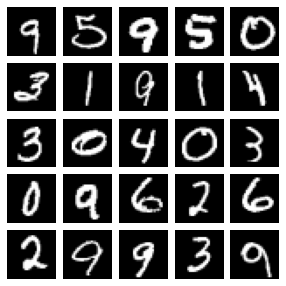

In [13]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [14]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    # def forward(self, x):
    #     mean, logvar = self.encode(x)
    #     z = self.reparameterization(mean, logvar)
    #     x_hat = self.decode(z)
    #     return x_hat, mean, log_var
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [15]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [16]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [17]:
def train(model, optimizer, epochs, device, data=train_loader, x_dim=784, expect_label=True):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(data):
            if expect_label:
                x, y = x
            x = x.view(x.size(), x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

# train(model, optimizer, epochs=50, device=device)

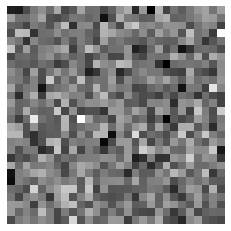

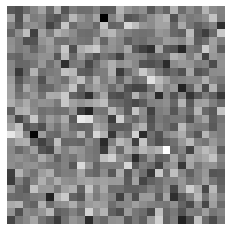

(None, None)

In [18]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

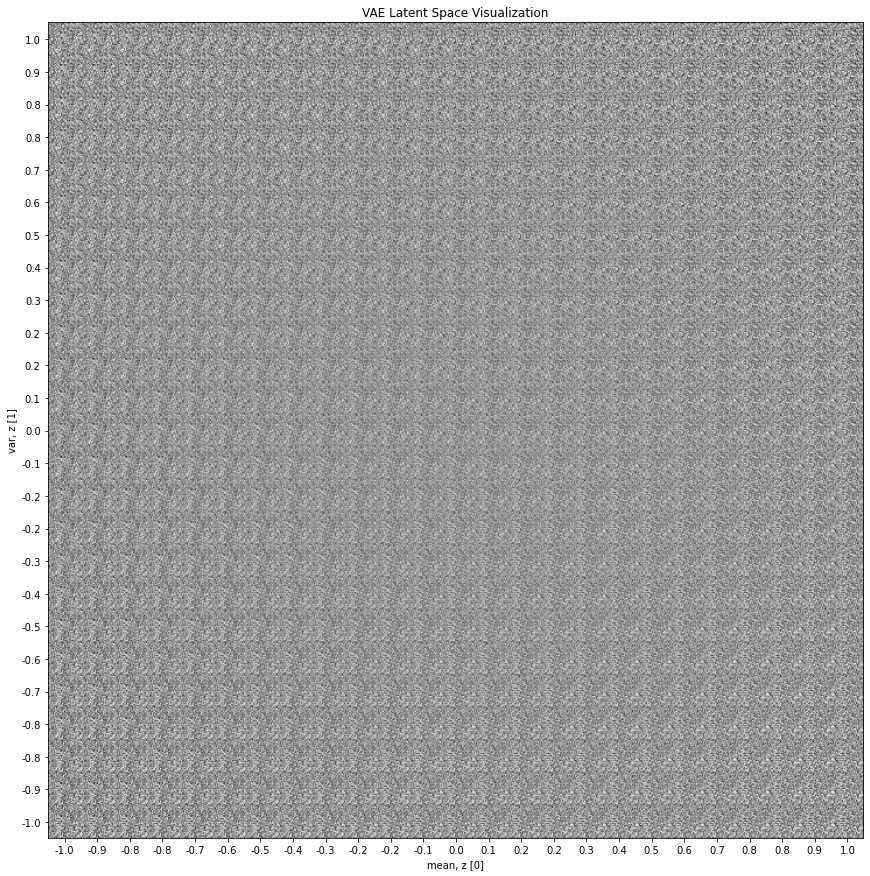

In [19]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

# <span style="color:red">FAUT MTN FAIRES AVECS LES CHATS 

In [17]:
64*64

4096

In [67]:
vae_chat = VAE(28*28, hidden_dim=500, latent_dim=100)

In [37]:
class CustomDataSet(Dataset):
    def __init__(self, csv_data, transform=None):
        self.df = csv_data
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        line = self.df.iloc[index, :]
        line = torch.tensor(minmax_scale(line), dtype=torch.float32)
        if self.transform:
            line = self.transform(line)
        return line

In [38]:
dataset_cat = CustomDataSet(data)

In [26]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [68]:
batch_size = 250
train_loader_cat = DataLoader(dataset=dataset_cat, batch_size=batch_size, shuffle=True)

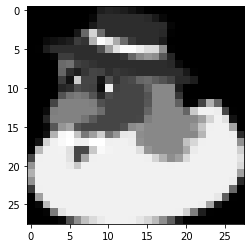

In [40]:
train_loader_cat
X = iter(train_loader_cat)
plt.imshow(next(X)[0].reshape(dims), cmap="Greys")

In [69]:
optimizer = optim.Adam(vae_chat.parameters(), lr=5e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
train(vae_chat, optimizer, 150, device, data=train_loader_cat, x_dim=40*40, expect_label=False)

	Epoch 1 	Average Loss:  484.6366036184211
	Epoch 2 	Average Loss:  382.1639095394737
	Epoch 3 	Average Loss:  362.2806480263158
	Epoch 4 	Average Loss:  359.18710855263157
	Epoch 5 	Average Loss:  357.2903832236842
	Epoch 6 	Average Loss:  354.2621513157895
	Epoch 7 	Average Loss:  348.8295773026316
	Epoch 8 	Average Loss:  345.0845296052632
	Epoch 9 	Average Loss:  342.7595164473684
	Epoch 10 	Average Loss:  341.48947861842106
	Epoch 11 	Average Loss:  340.5412434210526
	Epoch 12 	Average Loss:  339.70086677631576
	Epoch 13 	Average Loss:  338.9372417763158
	Epoch 14 	Average Loss:  337.984875
	Epoch 15 	Average Loss:  336.5941134868421
	Epoch 16 	Average Loss:  335.07662993421053
	Epoch 17 	Average Loss:  334.16410361842105
	Epoch 18 	Average Loss:  333.19452138157897
	Epoch 19 	Average Loss:  332.4900148026316
	Epoch 20 	Average Loss:  331.99854111842103
	Epoch 21 	Average Loss:  331.3488782894737
	Epoch 22 	Average Loss:  330.9464835526316
	Epoch 23 	Average Loss:  330.57444407894

1517068.8359375

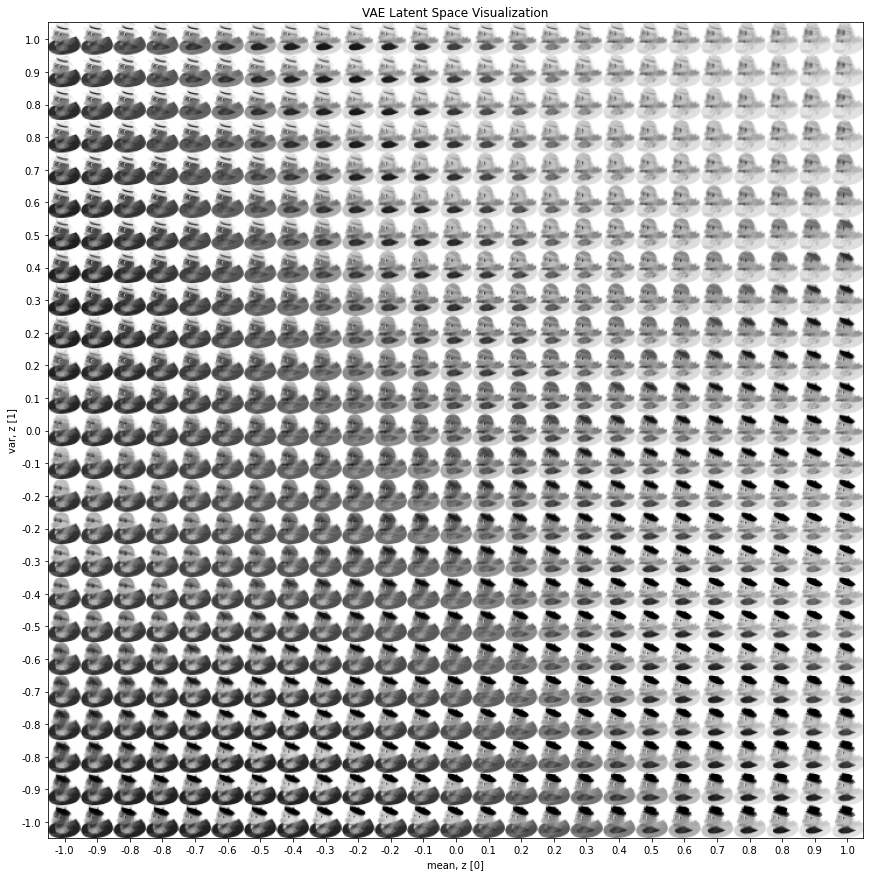

In [71]:
plot_latent_space(vae_chat, digit_size=dims[0])